In [9]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
# Aplicação do HDBSCAN
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [10]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5","exams_part12.hdf5", "exams_part13.hdf5", "exams_part10.hdf5", "exams_part11.hdf5","exams_part9.hdf5", "exams_part8.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False ) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == True) & 
                                (dados.iloc[:, 9] == False)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == True) & 
                                (dados.iloc[:, 9] == False)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

ecg_doente = ecg_doente_id[:3000]
ecg_normal = ecg_normal_id[:8000]

ids_ecgs = ecg_doente + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 73700
Número de linhas ecg_doente_linhas: 3809
Tirando Interferência:
Número de linhas ecg_normal_linhas: 71713
Número de linhas ecg_doente_linhas: 3748
Número de ecgs pra clusterizar: 11000


In [11]:
# Função para obter dados de ECG de um arquivo HDF5
def get_ecg_data(file_paths, exam_id):
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) != 0:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings
    raise ValueError("Exam ID não encontrado em nenhum dos arquivos fornecidos.")

# Caminhos para os arquivos HDF5
file_paths = ['../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5']



# Obter os tracings de ECG para cada exam_id e armazenar na lista
all_tracings = []
for exam_id in ids_ecgs:
    tracings = get_ecg_data(file_paths, exam_id)
    #Selecionar as leads V1 (índice 6) e V6 (índice 11)
    #lead_v1 = tracings[:, 6]
    #lead_v6 = tracings[:, 11]
    lead_d2 = tracings[:, 1]
    #Combinar as leads V1 e V6 em uma única dimensão
    #combined_leads = np.concatenate((lead_v1, lead_v6))
    all_tracings.append(lead_d2)

# Converter lista para array numpy
X = np.array(all_tracings)

print("Shape de X para o autoencoder:", X.shape)
# X agora está pronto para ser usado no autoencoder

Shape de X para o autoencoder: (11000, 4096)


In [66]:
#CARREGAR MODELO

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

# Define the encoder
def encoder_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=128, kernel_size=16, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=64, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=64, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=128, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    encoded = Conv1D(filters=1, kernel_size=16, strides=1, padding='same')(x)

    return Model(inputs, encoded, name="encoder")

# Define the decoder
def decoder_model(encoded_shape):
    inputs = Input(shape=encoded_shape)
    x = Conv1DTranspose(filters=128, kernel_size=16, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1DTranspose(filters=64, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=64, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=128, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    decoded = Conv1DTranspose(filters=1, kernel_size=16, strides=2, padding='same')(x)

    return Model(inputs, decoded, name="decoder")

# Define the full autoencoder
def autoencoder_model(input_shape):
    encoder = encoder_model(input_shape)
    decoder = decoder_model(encoder.output_shape[1:])
    
    inputs = Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    
    autoencoder = Model(inputs, decoded, name="autoencoder")
    
    return autoencoder




Epoch 1/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 137ms/step - loss: 0.0328 - val_loss: 0.0078
Epoch 2/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 121s 219ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 3/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 122s 223ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 4/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 126s 229ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 128s 233ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 86s 156ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 110s 201ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 110s 201ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 133s 243ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 131s 238ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 11/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 129s 234ms/step - loss: 9.6504e-04 - val_loss: 0.0012
Epoch 

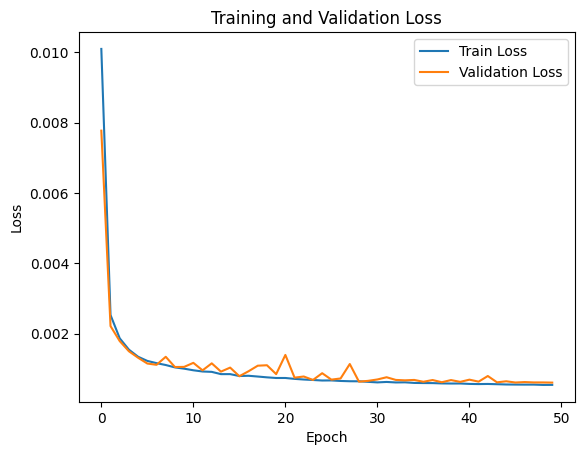

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


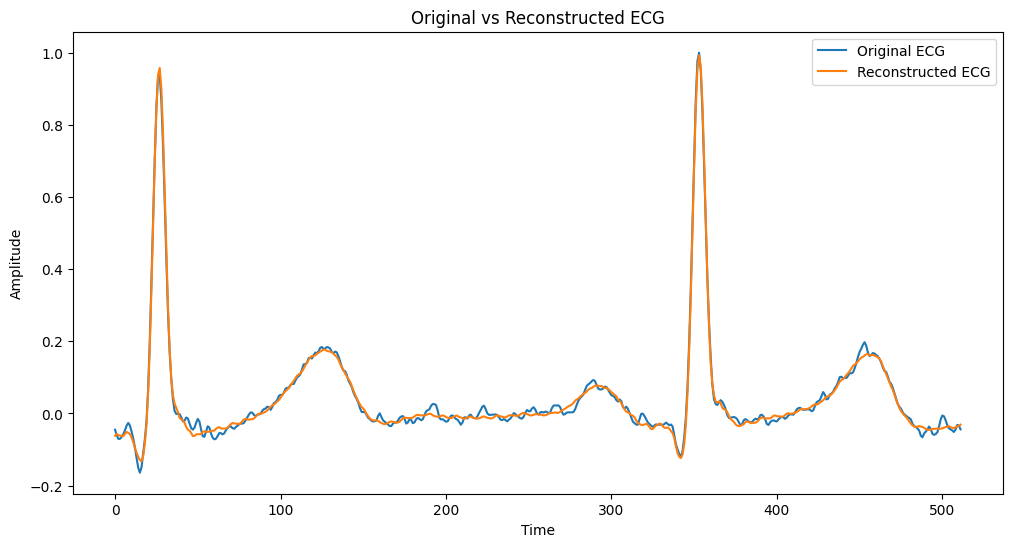

In [68]:
#EXECUTAR MODELO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# Se ainda não estiver carregado, use np.load() ou outra forma de carregar seus dados

epsilon = 1e-8  # Pequeno valor para evitar divisão por zero
X = X / (np.max(np.abs(X), axis=1, keepdims=True) + epsilon)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Definir o autoencoder
autoencoder = autoencoder_model((512, 1))
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar o modelo
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), callbacks=[early_stopping])

# Plotar a perda de treino e validação
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test[idx]

# Reconstruir o ECG usando o autoencoder
reconstructed_ecg = autoencoder.predict(np.expand_dims(original_ecg, axis=0))

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()

# Salvar o modelo treinado no formato Keras
autoencoder.save('autoencoder_model_512_input.keras')

# Salvar o modelo treinado
autoencoder.save('autoencoder_model_512_input.h5')


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=40, kernel_size=16, stride=2, padding=7)
        self.bn1 = nn.BatchNorm1d(40)
        
        self.conv2 = nn.Conv1d(in_channels=40, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.bn2 = nn.BatchNorm1d(20)
        
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.bn3 = nn.BatchNorm1d(20)
        
        self.conv4 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.bn4 = nn.BatchNorm1d(20)
        
        self.conv5 = nn.Conv1d(in_channels=20, out_channels=40, kernel_size=16, stride=2, padding=7)
        self.bn5 = nn.BatchNorm1d(40)
        
        self.conv6 = nn.Conv1d(in_channels=40, out_channels=1, kernel_size=16, stride=1, padding=7)
        self.bn6 = nn.BatchNorm1d(1)

    def forward(self, x):
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = F.elu(self.bn5(self.conv5(x)))
        x = self.bn6(self.conv6(x))  # Sem função de ativação na última camada
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose1d(in_channels=1, out_channels=40, kernel_size=16, stride=1, padding=7)
        self.bn1 = nn.BatchNorm1d(40)
        
        self.deconv2 = nn.ConvTranspose1d(in_channels=40, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.bn2 = nn.BatchNorm1d(20)
        
        self.deconv3 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.bn3 = nn.BatchNorm1d(20)
        
        self.deconv4 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.bn4 = nn.BatchNorm1d(20)
        
        self.deconv5 = nn.ConvTranspose1d(in_channels=20, out_channels=40, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.bn5 = nn.BatchNorm1d(40)
        
        self.deconv6 = nn.ConvTranspose1d(in_channels=40, out_channels=1, kernel_size=16, stride=2, padding=7, output_padding=0)

    def forward(self, x):
        x = F.elu(self.bn1(self.deconv1(x)))
        x = F.elu(self.bn2(self.deconv2(x)))
        x = F.elu(self.bn3(self.deconv3(x)))
        x = F.elu(self.bn4(self.deconv4(x)))
        x = F.elu(self.bn5(self.deconv5(x)))
        x = self.deconv6(x)  # Sem função de ativação na última camada
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded




Formato original de X: (11000, 4096)
Formato antes do reshape: (11000, 4096)
Formato após o reshape: (11000, 1, 4096)
Número total de elementos: 45056000


Epoch 1/50: 100%|██████████| 275/275 [00:01<00:00, 142.88it/s]


Epoch 1, Train Loss: 0.0546, Validation Loss: 0.0182


Epoch 2/50: 100%|██████████| 275/275 [00:01<00:00, 156.72it/s]


Epoch 2, Train Loss: 0.0170, Validation Loss: 0.0162


Epoch 3/50: 100%|██████████| 275/275 [00:01<00:00, 170.54it/s]


Epoch 3, Train Loss: 0.0145, Validation Loss: 0.0120


Epoch 4/50: 100%|██████████| 275/275 [00:01<00:00, 169.35it/s]


Epoch 4, Train Loss: 0.0097, Validation Loss: 0.0067


Epoch 5/50: 100%|██████████| 275/275 [00:01<00:00, 168.34it/s]


Epoch 5, Train Loss: 0.0060, Validation Loss: 0.0051


Epoch 6/50: 100%|██████████| 275/275 [00:01<00:00, 169.87it/s]


Epoch 6, Train Loss: 0.0046, Validation Loss: 0.0039


Epoch 7/50: 100%|██████████| 275/275 [00:01<00:00, 169.78it/s]


Epoch 7, Train Loss: 0.0040, Validation Loss: 0.0035


Epoch 8/50: 100%|██████████| 275/275 [00:01<00:00, 168.40it/s]


Epoch 8, Train Loss: 0.0036, Validation Loss: 0.0030


Epoch 9/50: 100%|██████████| 275/275 [00:01<00:00, 169.88it/s]


Epoch 9, Train Loss: 0.0033, Validation Loss: 0.0031


Epoch 10/50: 100%|██████████| 275/275 [00:01<00:00, 167.60it/s]


Epoch 10, Train Loss: 0.0032, Validation Loss: 0.0029


Epoch 11/50: 100%|██████████| 275/275 [00:01<00:00, 168.83it/s]


Epoch 11, Train Loss: 0.0030, Validation Loss: 0.0027


Epoch 12/50: 100%|██████████| 275/275 [00:01<00:00, 168.81it/s]


Epoch 12, Train Loss: 0.0029, Validation Loss: 0.0025


Epoch 13/50: 100%|██████████| 275/275 [00:01<00:00, 169.43it/s]


Epoch 13, Train Loss: 0.0028, Validation Loss: 0.0027


Epoch 14/50: 100%|██████████| 275/275 [00:01<00:00, 169.32it/s]


Epoch 14, Train Loss: 0.0027, Validation Loss: 0.0024


Epoch 15/50: 100%|██████████| 275/275 [00:01<00:00, 171.16it/s]


Epoch 15, Train Loss: 0.0026, Validation Loss: 0.0025


Epoch 16/50: 100%|██████████| 275/275 [00:01<00:00, 167.02it/s]


Epoch 16, Train Loss: 0.0026, Validation Loss: 0.0029


Epoch 17/50: 100%|██████████| 275/275 [00:01<00:00, 166.62it/s]


Epoch 17, Train Loss: 0.0025, Validation Loss: 0.0024


Epoch 18/50: 100%|██████████| 275/275 [00:01<00:00, 167.25it/s]


Epoch 18, Train Loss: 0.0025, Validation Loss: 0.0023


Epoch 19/50: 100%|██████████| 275/275 [00:01<00:00, 168.66it/s]


Epoch 19, Train Loss: 0.0024, Validation Loss: 0.0026


Epoch 20/50: 100%|██████████| 275/275 [00:01<00:00, 167.32it/s]


Epoch 20, Train Loss: 0.0025, Validation Loss: 0.0022


Epoch 21/50: 100%|██████████| 275/275 [00:01<00:00, 169.25it/s]


Epoch 21, Train Loss: 0.0024, Validation Loss: 0.0023


Epoch 22/50: 100%|██████████| 275/275 [00:01<00:00, 166.66it/s]


Epoch 22, Train Loss: 0.0023, Validation Loss: 0.0021


Epoch 23/50: 100%|██████████| 275/275 [00:01<00:00, 169.39it/s]


Epoch 23, Train Loss: 0.0023, Validation Loss: 0.0020


Epoch 24/50: 100%|██████████| 275/275 [00:01<00:00, 169.37it/s]


Epoch 24, Train Loss: 0.0022, Validation Loss: 0.0021


Epoch 25/50: 100%|██████████| 275/275 [00:01<00:00, 167.56it/s]


Epoch 25, Train Loss: 0.0022, Validation Loss: 0.0028


Epoch 26/50: 100%|██████████| 275/275 [00:01<00:00, 167.80it/s]


Epoch 26, Train Loss: 0.0022, Validation Loss: 0.0020


Epoch 27/50: 100%|██████████| 275/275 [00:01<00:00, 170.63it/s]


Epoch 27, Train Loss: 0.0021, Validation Loss: 0.0022


Epoch 28/50: 100%|██████████| 275/275 [00:01<00:00, 166.38it/s]


Epoch 28, Train Loss: 0.0021, Validation Loss: 0.0022


Epoch 29/50: 100%|██████████| 275/275 [00:01<00:00, 167.15it/s]


Epoch 29, Train Loss: 0.0021, Validation Loss: 0.0022


Epoch 30/50: 100%|██████████| 275/275 [00:01<00:00, 166.74it/s]


Epoch 30, Train Loss: 0.0020, Validation Loss: 0.0020


Epoch 31/50: 100%|██████████| 275/275 [00:01<00:00, 166.43it/s]


Epoch 31, Train Loss: 0.0020, Validation Loss: 0.0020


Epoch 32/50: 100%|██████████| 275/275 [00:01<00:00, 166.03it/s]


Epoch 32, Train Loss: 0.0020, Validation Loss: 0.0019


Epoch 33/50: 100%|██████████| 275/275 [00:01<00:00, 169.78it/s]


Epoch 33, Train Loss: 0.0019, Validation Loss: 0.0020


Epoch 34/50: 100%|██████████| 275/275 [00:01<00:00, 166.69it/s]


Epoch 34, Train Loss: 0.0019, Validation Loss: 0.0021


Epoch 35/50: 100%|██████████| 275/275 [00:01<00:00, 166.67it/s]


Epoch 35, Train Loss: 0.0019, Validation Loss: 0.0019


Epoch 36/50: 100%|██████████| 275/275 [00:01<00:00, 169.94it/s]


Epoch 36, Train Loss: 0.0019, Validation Loss: 0.0019


Epoch 37/50: 100%|██████████| 275/275 [00:01<00:00, 166.82it/s]


Epoch 37, Train Loss: 0.0019, Validation Loss: 0.0018


Epoch 38/50: 100%|██████████| 275/275 [00:01<00:00, 169.01it/s]


Epoch 38, Train Loss: 0.0019, Validation Loss: 0.0018


Epoch 39/50: 100%|██████████| 275/275 [00:01<00:00, 167.89it/s]


Epoch 39, Train Loss: 0.0018, Validation Loss: 0.0018


Epoch 40/50: 100%|██████████| 275/275 [00:01<00:00, 170.32it/s]


Epoch 40, Train Loss: 0.0018, Validation Loss: 0.0017


Epoch 41/50: 100%|██████████| 275/275 [00:01<00:00, 170.48it/s]


Epoch 41, Train Loss: 0.0018, Validation Loss: 0.0018


Epoch 42/50: 100%|██████████| 275/275 [00:01<00:00, 166.57it/s]


Epoch 42, Train Loss: 0.0017, Validation Loss: 0.0018


Epoch 43/50: 100%|██████████| 275/275 [00:01<00:00, 166.88it/s]


Epoch 43, Train Loss: 0.0018, Validation Loss: 0.0017


Epoch 44/50: 100%|██████████| 275/275 [00:01<00:00, 167.55it/s]


Epoch 44, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 45/50: 100%|██████████| 275/275 [00:01<00:00, 166.85it/s]


Epoch 45, Train Loss: 0.0017, Validation Loss: 0.0018


Epoch 46/50: 100%|██████████| 275/275 [00:01<00:00, 167.31it/s]


Epoch 46, Train Loss: 0.0017, Validation Loss: 0.0018


Epoch 47/50: 100%|██████████| 275/275 [00:01<00:00, 178.53it/s]


Epoch 47, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 48/50: 100%|██████████| 275/275 [00:01<00:00, 169.05it/s]


Epoch 48, Train Loss: 0.0016, Validation Loss: 0.0017


Epoch 49/50: 100%|██████████| 275/275 [00:01<00:00, 167.66it/s]


Epoch 49, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 50/50: 100%|██████████| 275/275 [00:01<00:00, 170.75it/s]


Epoch 50, Train Loss: 0.0016, Validation Loss: 0.0016


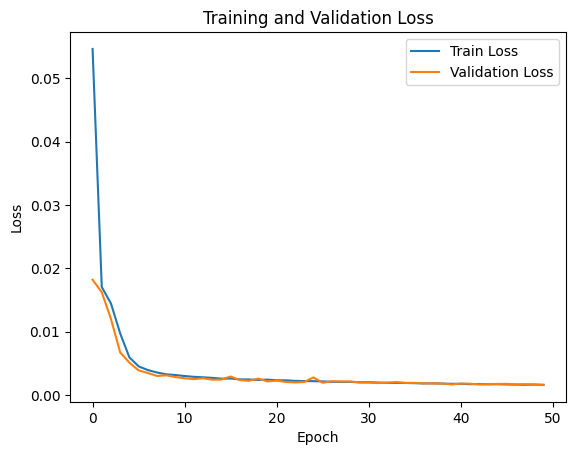

/tmp/ipykernel_381715/3449850615.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))


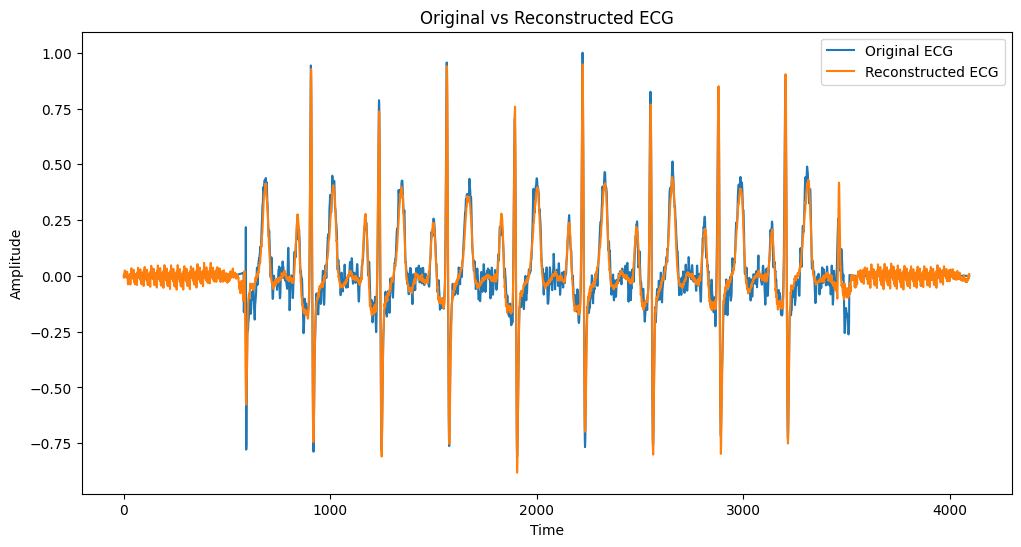

In [13]:
#EXECUTAR MODELO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# Se ainda não estiver carregado, use np.load() ou outra forma de carregar seus dados
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
print("Formato original de X:", X.shape)
epsilon = 1e-8
X = X / (np.max(np.abs(X), axis=1, keepdims=True) + epsilon)

print("Formato antes do reshape:", X.shape)
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("Formato após o reshape:", X.shape)

total_elements = np.prod(X.shape)
print("Número total de elementos:", total_elements)
# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Convertendo os dados para tensores do PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Criar DataLoaders para treino e teste
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Instanciar o modelo e mover para a GPU se disponível
autoencoder = Autoencoder().to(device)

# Definir o otimizador e a função de perda
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Treinar o modelo
num_epochs = 50
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = data[0]
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0]
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Plotar a perda de treino e validação
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Carregar o melhor modelo
autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test_tensor[idx].unsqueeze(0)

# Reconstruir o ECG usando o autoencoder
autoencoder.eval()
with torch.no_grad():
    reconstructed_ecg = autoencoder(original_ecg)

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.cpu().numpy().flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.cpu().numpy().flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()